# Purpose of notebook
This notebook is explore the roles classification problem. The goal of this analysis is to identify what attributes are good at predicting match outcomes, in different senarios. 

Topics covered:
- data pre-processing
- decision tree model (baseline model?)
    - Overall round dataset
    - Data set broken up by attacker vs defender

Roles questions:
1. If I group the data by characters into the 4 classes (duelist, initiator, controller, sentinel) can I classify the data based on those classes (those are the labels)
    1. Ideally I would be able to see which features are driving the classification per class and in total?
2. Is it possible to cluster the data?
    1. I think features could be less important in the sense that we could observe the grouping and see what roles make sense from the data?
    2. We make this the new classes and similarly try to classify

## Additional background / hypothesis
* Commonly in gaming there is the concept of "role" similar to positions in sports
* In Valorant, characters are grouped into 4 main roles and their "kit" is designed to fill that role
    - Controller
    - Initiator
    - Duelist
    - Sentinels
* Some characters are a bit fluid (can play multiple roles) but generally the character is a good proxy for role
* However the player can ignore the kit/character and still play a different "role" even if their character isnt designed for it
* There are sub-roles
* There is a general idea that in order to have the best chance of winning, you should have a 2 sentinels, 1 initiator, 1 duelist, 1 controller

### Hypothesis/questions
* Is it possible to group players by their gameplay (how different is their gameplay)?
    * Idea: we know the different people's ids, if we cluster the data and see how many clusters it forms (DBSCAN?) will it be similar or different to the ammount of people we have?
* Is it possible to determine how well a player is playing the role assigned by the character but independent of character?
    * Idea: we gather data from the "best" professionals in each character role, and treat this as the ground truth for that role
        * then we can measure how close a player is playing that role
        * could also attempt to classify based on the ground truth
* It it possible to prove/disprove the team-comp sentiment?
    * Idea: once we have a good idea of what leads to wins/losses, we can add in different character comps and see how that influeces match outcomes? basically try and see if the ratio of characters/roles actually matters
* Is it possible to show that certain characters/roles are more important/relevant depending on the STATE of the match (what has happened??)
    * Idea: classify/catagorize matches into opening, mid, end game based on events (like chess) to determine strategy, and then see which roles are most effective at progressing the match to the next event.

Defensive:
- sentinels: support and/or in game leader
    - healing 
    - moving around the map (information)
    -Cypher; Killjoy; Chamber; and Sage
    - slowing down opponents on bomb site

- initiators: recon and crowd control
    - Sova, Skye, Fade and Gekko rely on their abilities to perform reconnaissance
    - Breach and KAY/O specialise in disrupting enemies in their path through the use of their crowd control abilities

Offensive
- controllers: secondary entry frag and lurker 
    - Ability smoke screen
    - Use abilities before spike plant
    - Astra; Brimstone; Omen; Harbor and Viper.
    - Second on the scene
    - Omen is a flank

- duelist: entry drag
    - Damage dealers
    - Jett; Phoenix; Raze; Reyna; Yoru and Neon.
    - First person on an area on a map
    - Good aim

    

https://www.pinnacle.com/en/esports-hub/betting-articles/valorant/roles-in-valorant/gx9jvkedjdeh2ygl#:~:text=the%20team%20wins.-,What%20are%20the%20different%20roles%20in%20VALORANT%3F,%2C%20Recon%2C%20and%20Crowd%20Control. 



In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
import matplotlib.pyplot as plt

## Loading the data

In [2]:
import pandas as pd

# Read the CSV files into separate DataFrames
df1 = pd.read_csv('clean_data_norm_round_allf_dev_data.csv')
df2 = pd.read_csv('clean_data_norm_round_allf_pro1_data.csv')
df3 = pd.read_csv('clean_data_norm_round_allf_pro2_data.csv')

# Concatenate the DataFrames vertically
df = pd.concat([df1, df2, df3], ignore_index=True)

df

,user_id,map,player,ally4_character,self_character,ally1_character,ally2_character,ally3_character,opponent5_character,opponent6_character,...,self_avg_ammo_reserve,self_total_firing_time,self_longest_gun_secondary,self_max_loadout_value,spike_planted,spike_time,self_total_ability_usage_1,self_total_ability_usage_2,self_total_ability_usage_3,self_total_ability_usage_4
0,1006,Pearl,1,phoenix,jett,gekko,cypher,astra,harbor,astra,...,24.000000,2200,none,3434.0,False,0,0,1,1,0
1,1006,Pearl,1,phoenix,jett,gekko,cypher,astra,harbor,astra,...,19.400000,8600,classic,5100.0,False,125000,1,0,1,1
2,1006,Pearl,1,phoenix,jett,gekko,cypher,astra,harbor,astra,...,18.222222,9800,classic,5100.0,True,278800,1,1,1,0
3,1006,Pearl,1,phoenix,jett,gekko,cypher,astra,harbor,astra,...,16.800000,7400,classic,5100.0,False,304600,1,0,1,0
4,1006,Pearl,1,phoenix,jett,gekko,cypher,astra,harbor,astra,...,14.142857,4400,classic,6750.0,False,369400,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28635,3795,unknown,0,breach,jett,skye,sova,reyna,jett,gekko,...,20.500000,2200,ghost,5100.0,False,1500672,1,0,1,0
28636,3795,unknown,0,breach,jett,skye,sova,reyna,jett,gekko,...,13.500000,0,ghost,5100.0,False,1569284,1,0,1,0
28637,3795,unknown,0,breach,jett,skye,sova,reyna,jett,gekko,...,18.000000,0,ghost,5100.0,True,1695907,0,0,0,0
28638,3795,unknown,0,breach,jett,skye,sova,reyna,jett,gekko,...,20.833333,5601,none,4924.0,True,1811328,1,0,0,1


In [3]:
# Find rows with NaN values
nan_rows = df[df.isnull().any(axis=1)]

# Print the rows with NaN values
nan_rows

,user_id,map,player,ally4_character,self_character,ally1_character,ally2_character,ally3_character,opponent5_character,opponent6_character,...,self_avg_ammo_reserve,self_total_firing_time,self_longest_gun_secondary,self_max_loadout_value,spike_planted,spike_time,self_total_ability_usage_1,self_total_ability_usage_2,self_total_ability_usage_3,self_total_ability_usage_4


In [4]:
df.columns[:100]

Index(['user_id', 'map', 'player', 'ally4_character', 'self_character',
       'ally1_character', 'ally2_character', 'ally3_character',
       'opponent5_character', 'opponent6_character', 'opponent7_character',
       'opponent8_character', 'opponent9_character', 'round_number',
       'round_info_ally_side', 'round_info_round_end', 'round_info_round_won',
       'round_info_round_start', 'ally4_elims', 'ally4_deaths',
       'ally4_assists', 'ally4_headshots', 'ally4_wallbangs',
       'ally4_first_bloods', 'self_elims', 'self_deaths', 'self_assists',
       'self_headshots', 'self_wallbangs', 'self_first_bloods', 'ally1_elims',
       'ally1_deaths', 'ally1_assists', 'ally1_headshots', 'ally1_wallbangs',
       'ally1_first_bloods', 'ally2_elims', 'ally2_deaths', 'ally2_assists',
       'ally2_headshots', 'ally2_wallbangs', 'ally2_first_bloods',
       'ally3_elims', 'ally3_deaths', 'ally3_assists', 'ally3_headshots',
       'ally3_wallbangs', 'ally3_first_bloods', 'opponent0_elims'

In [5]:
df.columns[100:]

Index(['self_avg_ammo_reserve', 'self_total_firing_time',
       'self_longest_gun_secondary', 'self_max_loadout_value', 'spike_planted',
       'spike_time', 'self_total_ability_usage_1',
       'self_total_ability_usage_2', 'self_total_ability_usage_3',
       'self_total_ability_usage_4'],
      dtype='object')

In [6]:
df.iloc[0][:50]

user_id                       1006
map                          Pearl
player                           1
ally4_character            phoenix
self_character                jett
ally1_character              gekko
ally2_character             cypher
ally3_character              astra
opponent5_character         harbor
opponent6_character          astra
opponent7_character           jett
opponent8_character        phoenix
opponent9_character        killjoy
round_number                     7
round_info_ally_side      attacker
round_info_round_end        124802
round_info_round_won          True
round_info_round_start        4723
ally4_elims                    0.0
ally4_deaths                   0.0
ally4_assists                  0.0
ally4_headshots                0.0
ally4_wallbangs                0.0
ally4_first_bloods             0.0
self_elims                     0.0
self_deaths                    1.0
self_assists                   0.0
self_headshots                 0.0
self_wallbangs      

In [7]:
df.iloc[0][50:]

opponent0_assists                     0.0
opponent0_headshots                   0.0
opponent0_wallbangs                   0.0
opponent0_first_bloods                0.0
opponent1_elims                       1.0
opponent1_deaths                      0.0
opponent1_assists                     0.0
opponent1_headshots                   1.0
opponent1_wallbangs                   0.0
opponent1_first_bloods                0.0
opponent2_elims                       0.0
opponent2_deaths                      1.0
opponent2_assists                     0.0
opponent2_headshots                   0.0
opponent2_wallbangs                   0.0
opponent2_first_bloods                0.0
opponent3_elims                       0.0
opponent3_deaths                      0.0
opponent3_assists                     0.0
opponent3_headshots                   0.0
opponent3_wallbangs                   0.0
opponent3_first_bloods                0.0
opponent4_elims                       0.0
opponent4_deaths                  

## Data pre-processing
- Dropped 2 cols I don't need
- Checked to see if there are NaNs and 'unknowns'
- Because map wasn't really seeming to be a major influence on W/L ratio I am leaving the unknowns in
- However attacker vs defender could probably be an issue...


- Translated the boolean cols to 0 and 1
- One-hot encode categorical variables
- StandardScaler for numeric ...

In [8]:
df = df.drop(['player','round_number'], axis=1)

### encoding boolean features


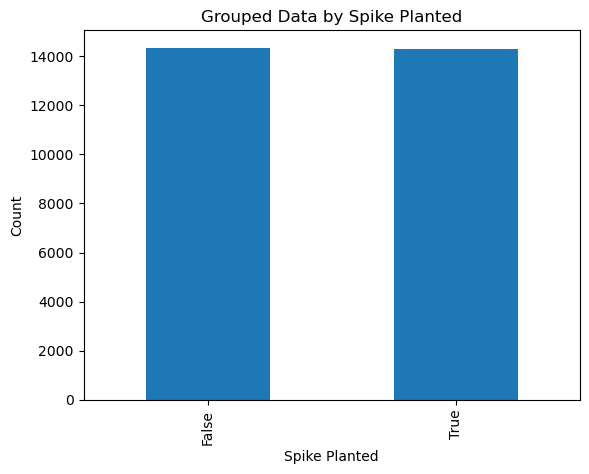

In [9]:
grouped_df = df.groupby('spike_planted').size()

grouped_df.plot(kind='bar')

plt.xlabel('Spike Planted')
plt.ylabel('Count')
plt.title('Grouped Data by Spike Planted')

plt.show()

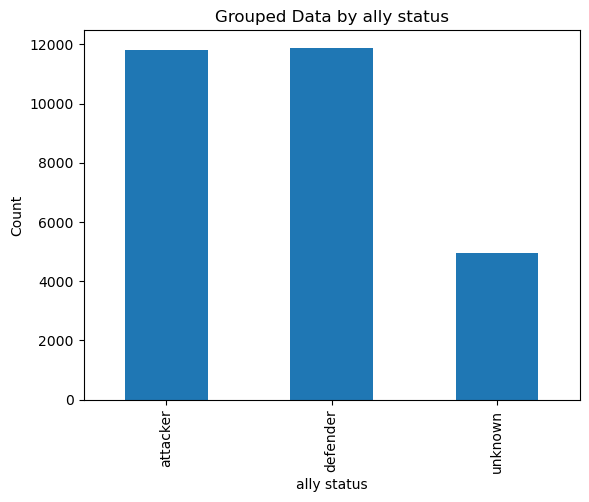

In [10]:
grouped_df = df.groupby('round_info_ally_side').size()

grouped_df.plot(kind='bar')

plt.xlabel('ally status')
plt.ylabel('Count')
plt.title('Grouped Data by ally status')

plt.show()

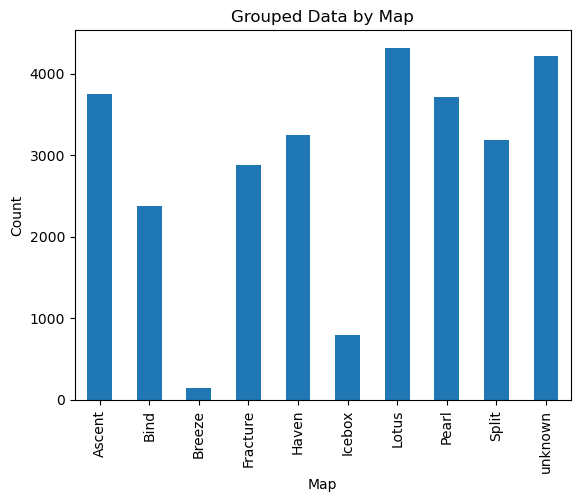

In [11]:
grouped_df = df.groupby('map').size()

grouped_df.plot(kind='bar')

plt.xlabel('Map')
plt.ylabel('Count')
plt.title('Grouped Data by Map')

plt.show()

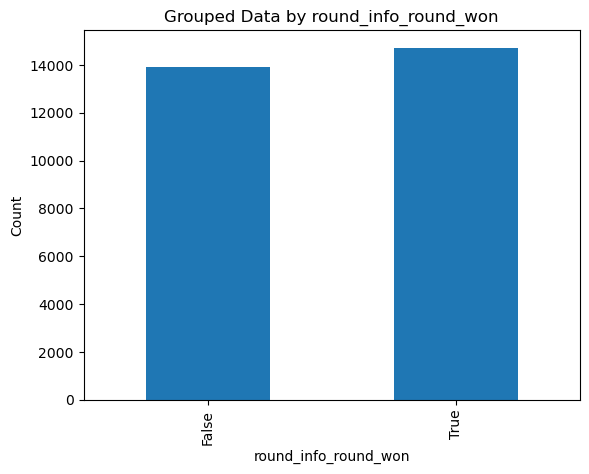

In [12]:
grouped_df = df.groupby('round_info_round_won').size()

grouped_df.plot(kind='bar')

plt.xlabel('round_info_round_won')
plt.ylabel('Count')
plt.title('Grouped Data by round_info_round_won')

plt.show()

In [13]:
mapping = {True: 1, False: 0}
df.loc[:, 'spike_planted'] = df['spike_planted'].map(mapping)
df

,user_id,map,ally4_character,self_character,ally1_character,ally2_character,ally3_character,opponent5_character,opponent6_character,opponent7_character,...,self_avg_ammo_reserve,self_total_firing_time,self_longest_gun_secondary,self_max_loadout_value,spike_planted,spike_time,self_total_ability_usage_1,self_total_ability_usage_2,self_total_ability_usage_3,self_total_ability_usage_4
0,1006,Pearl,phoenix,jett,gekko,cypher,astra,harbor,astra,jett,...,24.000000,2200,none,3434.0,0,0,0,1,1,0
1,1006,Pearl,phoenix,jett,gekko,cypher,astra,harbor,astra,jett,...,19.400000,8600,classic,5100.0,0,125000,1,0,1,1
2,1006,Pearl,phoenix,jett,gekko,cypher,astra,harbor,astra,jett,...,18.222222,9800,classic,5100.0,1,278800,1,1,1,0
3,1006,Pearl,phoenix,jett,gekko,cypher,astra,harbor,astra,jett,...,16.800000,7400,classic,5100.0,0,304600,1,0,1,0
4,1006,Pearl,phoenix,jett,gekko,cypher,astra,harbor,astra,jett,...,14.142857,4400,classic,6750.0,0,369400,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28635,3795,unknown,breach,jett,skye,sova,reyna,jett,gekko,omen,...,20.500000,2200,ghost,5100.0,0,1500672,1,0,1,0
28636,3795,unknown,breach,jett,skye,sova,reyna,jett,gekko,omen,...,13.500000,0,ghost,5100.0,0,1569284,1,0,1,0
28637,3795,unknown,breach,jett,skye,sova,reyna,jett,gekko,omen,...,18.000000,0,ghost,5100.0,1,1695907,0,0,0,0
28638,3795,unknown,breach,jett,skye,sova,reyna,jett,gekko,omen,...,20.833333,5601,none,4924.0,1,1811328,1,0,0,1


In [14]:
mapping = {True: 1, False: 0}
df.loc[:, 'round_info_round_won'] = df['round_info_round_won'].map(mapping)
df

,user_id,map,ally4_character,self_character,ally1_character,ally2_character,ally3_character,opponent5_character,opponent6_character,opponent7_character,...,self_avg_ammo_reserve,self_total_firing_time,self_longest_gun_secondary,self_max_loadout_value,spike_planted,spike_time,self_total_ability_usage_1,self_total_ability_usage_2,self_total_ability_usage_3,self_total_ability_usage_4
0,1006,Pearl,phoenix,jett,gekko,cypher,astra,harbor,astra,jett,...,24.000000,2200,none,3434.0,0,0,0,1,1,0
1,1006,Pearl,phoenix,jett,gekko,cypher,astra,harbor,astra,jett,...,19.400000,8600,classic,5100.0,0,125000,1,0,1,1
2,1006,Pearl,phoenix,jett,gekko,cypher,astra,harbor,astra,jett,...,18.222222,9800,classic,5100.0,1,278800,1,1,1,0
3,1006,Pearl,phoenix,jett,gekko,cypher,astra,harbor,astra,jett,...,16.800000,7400,classic,5100.0,0,304600,1,0,1,0
4,1006,Pearl,phoenix,jett,gekko,cypher,astra,harbor,astra,jett,...,14.142857,4400,classic,6750.0,0,369400,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28635,3795,unknown,breach,jett,skye,sova,reyna,jett,gekko,omen,...,20.500000,2200,ghost,5100.0,0,1500672,1,0,1,0
28636,3795,unknown,breach,jett,skye,sova,reyna,jett,gekko,omen,...,13.500000,0,ghost,5100.0,0,1569284,1,0,1,0
28637,3795,unknown,breach,jett,skye,sova,reyna,jett,gekko,omen,...,18.000000,0,ghost,5100.0,1,1695907,0,0,0,0
28638,3795,unknown,breach,jett,skye,sova,reyna,jett,gekko,omen,...,20.833333,5601,none,4924.0,1,1811328,1,0,0,1


In [15]:
# Find rows with NaN values
nan_rows = df[df.isnull().any(axis=1)]

# Print the rows with NaN values
nan_rows

,user_id,map,ally4_character,self_character,ally1_character,ally2_character,ally3_character,opponent5_character,opponent6_character,opponent7_character,...,self_avg_ammo_reserve,self_total_firing_time,self_longest_gun_secondary,self_max_loadout_value,spike_planted,spike_time,self_total_ability_usage_1,self_total_ability_usage_2,self_total_ability_usage_3,self_total_ability_usage_4


### one-hot encoding 

In [16]:
df_encoded = pd.get_dummies(df, columns=['map', 'ally4_character', 
                                            'ally1_character', 'ally2_character', 'ally3_character', 
                                            'opponent5_character', 'opponent6_character', 'opponent7_character',
                                            'opponent8_character', 'opponent9_character',
                                               'round_info_ally_side','self_longest_inv_state', 
                                               'self_longest_gun_primary','self_longest_gun_secondary'])


In [17]:
df_encoded

,user_id,self_character,round_info_round_end,round_info_round_won,round_info_round_start,ally4_elims,ally4_deaths,ally4_assists,ally4_headshots,ally4_wallbangs,...,self_longest_gun_primary_phantom,self_longest_gun_primary_spectre,self_longest_gun_primary_stinger,self_longest_gun_primary_vandal,self_longest_gun_secondary_classic,self_longest_gun_secondary_frenzy,self_longest_gun_secondary_ghost,self_longest_gun_secondary_none,self_longest_gun_secondary_sheriff,self_longest_gun_secondary_shorty
0,1006,jett,124802,1,4723,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,1,0,0
1,1006,jett,204402,1,154802,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,1,0,0,0,0,0
2,1006,jett,304570,1,234402,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,1,0,0,0,0,0
3,1006,jett,369242,1,334570,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
4,1006,jett,448998,1,399242,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28635,3795,jett,1569092,1,1530671,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,1,0,0,0
28636,3795,jett,1632898,1,1599092,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
28637,3795,jett,1732124,0,1662898,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
28638,3795,jett,1834542,1,1762124,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,1,0,0


## round length

In [18]:
df_encoded['round_info_round_length'] = df_encoded['round_info_round_end'] - df_encoded['round_info_round_start']

## encode by role

In [19]:
unique_chars = df_encoded['self_character'].unique()
unique_chars

array(['jett', 'gekko', 'breach', 'fade', 'killjoy', 'viper', 'raze',
       'brimstone', 'sage', 'omen', 'kay/o', 'reyna', 'sova', 'harbor',
       'astra', 'cypher', 'skye', 'neon', 'phoenix', 'chamber', 'yoru'],
      dtype=object)

In [20]:
mapping = {'killjoy':0, 'cypher':0, 'sage':0,'chamber':0, 
           'brimstone':1, 'omen':1,'viper':1,'astra':1,'harbor':1,
          'jett':2, 'phoenix':2,'raze':2, 'reyna':2,'neon':2, 'yoru':2,
           'gekko':3, 'breach':3, 'fade':3, 'kay/o':3, 'skye':3,'sova':3}
df_encoded.loc[:, 'self_character'] = df_encoded['self_character'].map(mapping)
df_encoded

,user_id,self_character,round_info_round_end,round_info_round_won,round_info_round_start,ally4_elims,ally4_deaths,ally4_assists,ally4_headshots,ally4_wallbangs,...,self_longest_gun_primary_spectre,self_longest_gun_primary_stinger,self_longest_gun_primary_vandal,self_longest_gun_secondary_classic,self_longest_gun_secondary_frenzy,self_longest_gun_secondary_ghost,self_longest_gun_secondary_none,self_longest_gun_secondary_sheriff,self_longest_gun_secondary_shorty,round_info_round_length
0,1006,2,124802,1,4723,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,1,0,0,120079
1,1006,2,204402,1,154802,0.0,0.0,0.0,0.0,0.0,...,0,0,1,1,0,0,0,0,0,49600
2,1006,2,304570,1,234402,0.0,0.0,0.0,0.0,0.0,...,0,0,1,1,0,0,0,0,0,70168
3,1006,2,369242,1,334570,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,34672
4,1006,2,448998,1,399242,0.0,0.0,0.0,0.0,0.0,...,0,0,1,1,0,0,0,0,0,49756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28635,3795,2,1569092,1,1530671,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,1,0,0,0,38421
28636,3795,2,1632898,1,1599092,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,33806
28637,3795,2,1732124,0,1662898,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,69226
28638,3795,2,1834542,1,1762124,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,72418


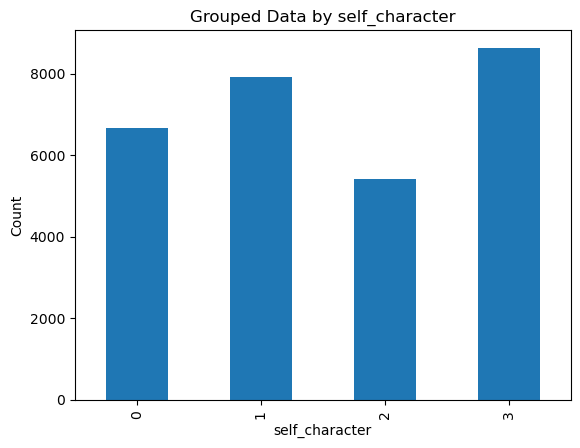

In [21]:
grouped_df = df_encoded.groupby('self_character').size()

grouped_df.plot(kind='bar')

plt.xlabel('self_character')
plt.ylabel('Count')
plt.title('Grouped Data by self_character')

plt.show()

In [22]:
# Find rows with NaN values
nan_rows = df_encoded[df_encoded.isnull().any(axis=1)]

# Print the rows with NaN values
nan_rows

,user_id,self_character,round_info_round_end,round_info_round_won,round_info_round_start,ally4_elims,ally4_deaths,ally4_assists,ally4_headshots,ally4_wallbangs,...,self_longest_gun_primary_spectre,self_longest_gun_primary_stinger,self_longest_gun_primary_vandal,self_longest_gun_secondary_classic,self_longest_gun_secondary_frenzy,self_longest_gun_secondary_ghost,self_longest_gun_secondary_none,self_longest_gun_secondary_sheriff,self_longest_gun_secondary_shorty,round_info_round_length


### Downsampling
-

## Decision Tree Classifier

### All data

In [23]:
df_dtree = df_encoded.copy()
df_dtree

,user_id,self_character,round_info_round_end,round_info_round_won,round_info_round_start,ally4_elims,ally4_deaths,ally4_assists,ally4_headshots,ally4_wallbangs,...,self_longest_gun_primary_spectre,self_longest_gun_primary_stinger,self_longest_gun_primary_vandal,self_longest_gun_secondary_classic,self_longest_gun_secondary_frenzy,self_longest_gun_secondary_ghost,self_longest_gun_secondary_none,self_longest_gun_secondary_sheriff,self_longest_gun_secondary_shorty,round_info_round_length
0,1006,2,124802,1,4723,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,1,0,0,120079
1,1006,2,204402,1,154802,0.0,0.0,0.0,0.0,0.0,...,0,0,1,1,0,0,0,0,0,49600
2,1006,2,304570,1,234402,0.0,0.0,0.0,0.0,0.0,...,0,0,1,1,0,0,0,0,0,70168
3,1006,2,369242,1,334570,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,34672
4,1006,2,448998,1,399242,0.0,0.0,0.0,0.0,0.0,...,0,0,1,1,0,0,0,0,0,49756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28635,3795,2,1569092,1,1530671,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,1,0,0,0,38421
28636,3795,2,1632898,1,1599092,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,33806
28637,3795,2,1732124,0,1662898,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,69226
28638,3795,2,1834542,1,1762124,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,72418


In [24]:
# train test split
X = df_dtree.drop('self_character', axis=1)
y = df_dtree['self_character']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# # Scale the data
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [25]:
def d_tree(X_train,y_train,X_test,y_test):
    dtc = DecisionTreeClassifier(random_state=1)
    dtc.fit(X_train, y_train)
    y_pred = dtc.predict(X_test)
    y_pred_train = dtc.predict(X_train)
    print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
    print(confusion_matrix(y_train, y_pred_train))
    print(classification_report(y_test, y_pred))

    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    return dtc

In [26]:
def f_importance(dtc):
    feature_importances = pd.DataFrame(dtc.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
    return feature_importances
    

In [27]:
dtc = d_tree(X_train,y_train,X_test,y_test)

Train Accuracy: 1.0
[[5350    0    0    0]
 [   0 6289    0    0]
 [   0    0 4334    0]
 [   0    0    0 6939]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1328
           1       1.00      1.00      1.00      1632
           2       1.00      0.99      0.99      1071
           3       1.00      1.00      1.00      1697

    accuracy                           1.00      5728
   macro avg       1.00      1.00      1.00      5728
weighted avg       1.00      1.00      1.00      5728

Test Accuracy: 0.9965083798882681
[[1328    0    0    0]
 [   1 1629    2    0]
 [   1    5 1062    3]
 [   2    3    3 1689]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1328
           1       1.00      1.00      1.00      1632
           2       1.00      0.99      0.99      1071
           3       1.00      1.00      1.00      1697

    accuracy                           1.00      5728

In [28]:
feature_importances = f_importance(dtc)

In [29]:
feature_importances[:50]

,importance
user_id,0.191987
ally4_character_omen,0.029667
opponent6_character_killjoy,0.027291
ally1_character_omen,0.024163
ally2_character_omen,0.023367
self_prec_map_covered,0.020085
ally3_character_skye,0.018205
opponent9_character_jett,0.017747
ally1_character_raze,0.016602
ally4_character_skye,0.016308


## trying again w no user id

In [41]:
df_no_userid = df_encoded.copy()
df_no_userid = df_no_userid.drop('user_id', axis=1)
df_no_userid

,self_character,round_info_round_end,round_info_round_won,round_info_round_start,ally4_elims,ally4_deaths,ally4_assists,ally4_headshots,ally4_wallbangs,ally4_first_bloods,...,self_longest_gun_primary_spectre,self_longest_gun_primary_stinger,self_longest_gun_primary_vandal,self_longest_gun_secondary_classic,self_longest_gun_secondary_frenzy,self_longest_gun_secondary_ghost,self_longest_gun_secondary_none,self_longest_gun_secondary_sheriff,self_longest_gun_secondary_shorty,round_info_round_length
0,2,124802,1,4723,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,1,0,0,120079
1,2,204402,1,154802,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,1,0,0,0,0,0,49600
2,2,304570,1,234402,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,1,0,0,0,0,0,70168
3,2,369242,1,334570,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,34672
4,2,448998,1,399242,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,1,0,0,0,0,0,49756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28635,2,1569092,1,1530671,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,1,0,0,0,38421
28636,2,1632898,1,1599092,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,33806
28637,2,1732124,0,1662898,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,69226
28638,2,1834542,1,1762124,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,72418


In [42]:
# train test split
X_nouser = df_no_userid.drop('self_character', axis=1)
y_nouser = df_no_userid['self_character']

X_train, X_test, y_train, y_test = train_test_split(X_nouser, y_nouser, test_size=0.2, random_state=1)

In [43]:
dtc_nouser = d_tree(X_train,y_train,X_test,y_test)

Train Accuracy: 1.0
[[5350    0    0    0]
 [   0 6289    0    0]
 [   0    0 4334    0]
 [   0    0    0 6939]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1328
           1       1.00      1.00      1.00      1632
           2       1.00      0.99      0.99      1071
           3       0.99      1.00      1.00      1697

    accuracy                           1.00      5728
   macro avg       1.00      0.99      1.00      5728
weighted avg       1.00      1.00      1.00      5728

Test Accuracy: 0.9954608938547486
[[1324    0    1    3]
 [   2 1628    1    1]
 [   4    3 1059    5]
 [   4    0    2 1691]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1328
           1       1.00      1.00      1.00      1632
           2       1.00      0.99      0.99      1071
           3       0.99      1.00      1.00      1697

    accuracy                           1.00      5728

In [44]:
feature_importances = f_importance(dtc_nouser)
feature_importances[:50]

,importance
opponent6_character_breach,0.028467
ally3_character_brimstone,0.026971
self_prec_map_covered,0.025385
ally1_character_omen,0.021865
ally1_avg_health,0.019429
opponent9_character_raze,0.018905
map_Fracture,0.017756
ally4_character_omen,0.017523
ally2_character_killjoy,0.017332
ally3_character_omen,0.017251


## trying again w no user id, team characters 

In [59]:
df_no_chars = df_no_userid.copy()
columns_to_drop = [col for col in df_no_chars.columns if col.startswith('ally3_character')]
df_no_chars.drop(columns_to_drop, axis=1, inplace=True)

columns_to_drop = [col for col in df_no_chars.columns if col.startswith('ally1_character')]
df_no_chars.drop(columns_to_drop, axis=1, inplace=True)

columns_to_drop = [col for col in df_no_chars.columns if col.startswith('ally2_character')]
df_no_chars.drop(columns_to_drop, axis=1, inplace=True)

columns_to_drop = [col for col in df_no_chars.columns if col.startswith('ally4_character')]
df_no_chars.drop(columns_to_drop, axis=1, inplace=True)

columns_to_drop = [col for col in df_no_chars.columns if col.startswith('opponent7_character')]
df_no_chars.drop(columns_to_drop, axis=1, inplace=True)

columns_to_drop = [col for col in df_no_chars.columns if col.startswith('opponent6_character')]
df_no_chars.drop(columns_to_drop, axis=1, inplace=True)

columns_to_drop = [col for col in df_no_chars.columns if col.startswith('opponent5_character')]
df_no_chars.drop(columns_to_drop, axis=1, inplace=True)

columns_to_drop = [col for col in df_no_chars.columns if col.startswith('opponent8_character')]
df_no_chars.drop(columns_to_drop, axis=1, inplace=True)

columns_to_drop = [col for col in df_no_chars.columns if col.startswith('opponent9_character')]
df_no_chars.drop(columns_to_drop, axis=1, inplace=True)

In [60]:
df_no_chars

,self_character,round_info_round_end,round_info_round_won,round_info_round_start,ally4_elims,ally4_deaths,ally4_assists,ally4_headshots,ally4_wallbangs,ally4_first_bloods,...,self_longest_gun_primary_spectre,self_longest_gun_primary_stinger,self_longest_gun_primary_vandal,self_longest_gun_secondary_classic,self_longest_gun_secondary_frenzy,self_longest_gun_secondary_ghost,self_longest_gun_secondary_none,self_longest_gun_secondary_sheriff,self_longest_gun_secondary_shorty,round_info_round_length
0,2,124802,1,4723,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,1,0,0,120079
1,2,204402,1,154802,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,1,0,0,0,0,0,49600
2,2,304570,1,234402,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,1,0,0,0,0,0,70168
3,2,369242,1,334570,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,34672
4,2,448998,1,399242,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,1,0,0,0,0,0,49756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28635,2,1569092,1,1530671,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,1,0,0,0,38421
28636,2,1632898,1,1599092,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,33806
28637,2,1732124,0,1662898,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,69226
28638,2,1834542,1,1762124,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,72418


In [61]:
# train test split
X_nocharnouser = df_no_chars.drop('self_character', axis=1)
y_nocharnouser= df_no_chars['self_character']

X_train, X_test, y_train, y_test = train_test_split(X_nocharnouser, y_nocharnouser, test_size=0.2, random_state=1)

In [62]:
dtc_nousernochar = d_tree(X_train,y_train,X_test,y_test)

Train Accuracy: 1.0
[[5350    0    0    0]
 [   0 6289    0    0]
 [   0    0 4334    0]
 [   0    0    0 6939]]
              precision    recall  f1-score   support

           0       0.70      0.71      0.71      1328
           1       0.78      0.77      0.78      1632
           2       0.55      0.53      0.54      1071
           3       0.74      0.76      0.75      1697

    accuracy                           0.71      5728
   macro avg       0.69      0.69      0.69      5728
weighted avg       0.71      0.71      0.71      5728

Test Accuracy: 0.7091480446927374
[[ 946  116  150  116]
 [ 131 1257  123  121]
 [ 159  136  564  212]
 [ 118   97  187 1295]]
              precision    recall  f1-score   support

           0       0.70      0.71      0.71      1328
           1       0.78      0.77      0.78      1632
           2       0.55      0.53      0.54      1071
           3       0.74      0.76      0.75      1697

    accuracy                           0.71      5728

In [63]:
feature_importances = f_importance(dtc_nousernochar)
feature_importances[:50]

,importance
self_max_loadout_value,0.137302
ally4_avg_health,0.069582
ally1_avg_health,0.059384
ally2_avg_health,0.057664
ally3_avg_health,0.056268
self_avg_credits,0.029706
self_prec_map_covered,0.028614
round_info_round_length,0.025556
self_total_firing_time,0.019952
map_Bind,0.019100


## trying again w no map

In [64]:
df_no_map = df_no_chars.copy()
columns_to_drop = [col for col in df_no_chars.columns if col.startswith('map_')]
df_no_map.drop(columns_to_drop, axis=1, inplace=True)
df_no_map

,self_character,round_info_round_end,round_info_round_won,round_info_round_start,ally4_elims,ally4_deaths,ally4_assists,ally4_headshots,ally4_wallbangs,ally4_first_bloods,...,self_longest_gun_primary_spectre,self_longest_gun_primary_stinger,self_longest_gun_primary_vandal,self_longest_gun_secondary_classic,self_longest_gun_secondary_frenzy,self_longest_gun_secondary_ghost,self_longest_gun_secondary_none,self_longest_gun_secondary_sheriff,self_longest_gun_secondary_shorty,round_info_round_length
0,2,124802,1,4723,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,1,0,0,120079
1,2,204402,1,154802,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,1,0,0,0,0,0,49600
2,2,304570,1,234402,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,1,0,0,0,0,0,70168
3,2,369242,1,334570,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,34672
4,2,448998,1,399242,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,1,0,0,0,0,0,49756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28635,2,1569092,1,1530671,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,1,0,0,0,38421
28636,2,1632898,1,1599092,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,33806
28637,2,1732124,0,1662898,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,69226
28638,2,1834542,1,1762124,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,72418


In [69]:
# train test split
X_nocharnousernomap = df_no_map.drop('self_character', axis=1)
y_nocharnousernomap = df_no_map['self_character']

X_train, X_test, y_train, y_test = train_test_split(X_nocharnousernomap, y_nocharnousernomap, test_size=0.2, random_state=1)

In [70]:
dtc_nousernocharnomap = d_tree(X_train,y_train,X_test,y_test)

Train Accuracy: 1.0
[[5350    0    0    0]
 [   0 6289    0    0]
 [   0    0 4334    0]
 [   0    0    0 6939]]
              precision    recall  f1-score   support

           0       0.69      0.70      0.69      1328
           1       0.76      0.74      0.75      1632
           2       0.53      0.51      0.52      1071
           3       0.73      0.76      0.75      1697

    accuracy                           0.69      5728
   macro avg       0.68      0.68      0.68      5728
weighted avg       0.69      0.69      0.69      5728

Test Accuracy: 0.6929120111731844
[[ 923  143  144  118]
 [ 130 1214  156  132]
 [ 157  155  541  218]
 [ 128   91  187 1291]]
              precision    recall  f1-score   support

           0       0.69      0.70      0.69      1328
           1       0.76      0.74      0.75      1632
           2       0.53      0.51      0.52      1071
           3       0.73      0.76      0.75      1697

    accuracy                           0.69      5728

#### feature_importances = f_importance(dtc_nousernocharnomap)
feature_importances[:50]

In [76]:
dtc_nousernocharnomap.get_depth()

37

In [82]:
dtc_nousernocharnomap.min_samples_leaf

1

In [112]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def d_tree_tuning(X_train, y_train, X_test, y_test):
    # Define the parameter grid for hyperparameter tuning
    param_grid = {
        'max_depth': [10, 20, 30],  # Example values for max_depth
        'min_samples_leaf': [1, 2, 3],  # Example values for min_samples_leaf
        'min_samples_split': [2, 5, 10]  # Example values for min_samples_split
    }

    # Create a decision tree classifier
    dtc = DecisionTreeClassifier(random_state=1)

    # Create a GridSearchCV object with the decision tree classifier and parameter grid
    grid_search = GridSearchCV(dtc, param_grid, cv=5)  # Adjust cv value as needed

    # Fit the GridSearchCV object to the training data
    grid_search.fit(X_train, y_train)

    # Retrieve the best hyperparameters and create a decision tree with those settings
    best_dtc = grid_search.best_estimator_

    # Predict on the training set using the best model
    y_pred_train = best_dtc.predict(X_train)

    # Predict on the test set using the best model
    y_pred = best_dtc.predict(X_test)

    # Print evaluation metrics for the training set
    print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
    print(confusion_matrix(y_train, y_pred_train))
    print(classification_report(y_train, y_pred_train))

    # Print evaluation metrics for the test set
    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    return best_dtc

In [113]:
dtc_tune = d_tree_tuning(X_train,y_train,X_test,y_test)

Train Accuracy: 0.9986469972067039
[[5341    4    0    5]
 [   0 6285    1    3]
 [   3    4 4325    2]
 [   2    7    0 6930]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5350
           1       1.00      1.00      1.00      6289
           2       1.00      1.00      1.00      4334
           3       1.00      1.00      1.00      6939

    accuracy                           1.00     22912
   macro avg       1.00      1.00      1.00     22912
weighted avg       1.00      1.00      1.00     22912

Test Accuracy: 0.6913407821229051
[[ 924  136  147  121]
 [ 143 1216  140  133]
 [ 151  160  530  230]
 [ 127   83  197 1290]]
              precision    recall  f1-score   support

           0       0.69      0.70      0.69      1328
           1       0.76      0.75      0.75      1632
           2       0.52      0.49      0.51      1071
           3       0.73      0.76      0.74      1697

    accuracy                          

In [114]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def random_forest(X_train, y_train, X_test, y_test):
    # Define the parameter grid for hyperparameter tuning
    param_grid = {
        'n_estimators': [50, 100, 200],  # Example values for n_estimators
        'max_depth': [10, 15, 20],  # Example values for max_depth
    }

    # Create a random forest classifier
    rfc = RandomForestClassifier(random_state=1)

    # Create a GridSearchCV object with the random forest classifier and parameter grid
    grid_search = GridSearchCV(rfc, param_grid, cv=5)  # Adjust cv value as needed

    # Fit the GridSearchCV object to the training data
    grid_search.fit(X_train, y_train)

    # Retrieve the best hyperparameters and create a random forest classifier with those settings
    best_rfc = grid_search.best_estimator_

    # Predict on the training set using the best model
    y_pred_train = best_rfc.predict(X_train)

    # Predict on the test set using the best model
    y_pred = best_rfc.predict(X_test)

    # Print evaluation metrics for the training set
    print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
    print(confusion_matrix(y_train, y_pred_train))
    print(classification_report(y_train, y_pred_train))

    # Print evaluation metrics for the test set
    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    return best_rfc


In [115]:
rf = random_forest(X_train,y_train,X_test,y_test)

Train Accuracy: 1.0
[[5350    0    0    0]
 [   0 6289    0    0]
 [   0    0 4334    0]
 [   0    0    0 6939]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5350
           1       1.00      1.00      1.00      6289
           2       1.00      1.00      1.00      4334
           3       1.00      1.00      1.00      6939

    accuracy                           1.00     22912
   macro avg       1.00      1.00      1.00     22912
weighted avg       1.00      1.00      1.00     22912

Test Accuracy: 0.7332402234636871
[[ 951   80  162  135]
 [ 105 1227  143  157]
 [ 101   90  648  232]
 [  99   91  133 1374]]
              precision    recall  f1-score   support

           0       0.76      0.72      0.74      1328
           1       0.82      0.75      0.79      1632
           2       0.60      0.61      0.60      1071
           3       0.72      0.81      0.76      1697

    accuracy                           0.73      5728

In [97]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

In [116]:
def tune_gbm(X_train, y_train):
    param_grid = {
        'n_estimators': [100, 200, 300],  # Vary the number of estimators
        'learning_rate': [0.1, 0.05, 0.01],  # Vary the learning rate
        'max_depth': [3, 4, 5]  # Vary the maximum depth of trees
    }

    gbc = GradientBoostingClassifier(random_state=1)

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(gbc, param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    # Print the best parameters found during tuning
    print("Best Parameters:", grid_search.best_params_)

    return grid_search.best_estimator_

def gradient_boosting(X_train, y_train, X_test, y_test):
    # Hyperparameter tuning and CV
    gbc_tuned = tune_gbm(X_train, y_train)
    gbc_tuned.fit(X_train, y_train)

    y_pred = gbc_tuned.predict(X_test)
    y_pred_train = gbc_tuned.predict(X_train)

    print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
    print(confusion_matrix(y_train, y_pred_train))
    print(classification_report(y_train, y_pred_train))

    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    return gbc_tuned


In [117]:
gbc = gradient_boosting(X_train,y_train,X_test,y_test)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
Train Accuracy: 0.9375872905027933
[[5079  103   88   80]
 [ 125 5952  101  111]
 [ 127  133 3837  237]
 [ 111   81  133 6614]]
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      5350
           1       0.95      0.95      0.95      6289
           2       0.92      0.89      0.90      4334
           3       0.94      0.95      0.95      6939

    accuracy                           0.94     22912
   macro avg       0.94      0.93      0.93     22912
weighted avg       0.94      0.94      0.94     22912

Test Accuracy: 0.7700768156424581
[[1036  107  106   79]
 [ 106 1307  108  111]
 [  98  113  666  194]
 [  87   87  121 1402]]
              precision    recall  f1-score   support

           0       0.78      0.78      0.78      1328
           1       0.81      0.80      0.81      1632
           2       0.67      0.62      0.64      1071
           3    

## Attacker/defender
- unfortunatly some rows are unknown so this is a slightly smaller dataset

In [67]:
downsampled_df

,user_id,round_info_round_end,round_info_round_won,round_info_round_start,ally4_elims,ally4_deaths,ally4_assists,ally4_headshots,ally4_wallbangs,ally4_first_bloods,...,self_longest_gun_primary_spectre,self_longest_gun_primary_stinger,self_longest_gun_primary_vandal,self_longest_gun_secondary_classic,self_longest_gun_secondary_frenzy,self_longest_gun_secondary_ghost,self_longest_gun_secondary_none,self_longest_gun_secondary_sheriff,self_longest_gun_secondary_shorty,round_info_round_length
0,69,169029,0,127194,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,1,0,0,0,0,0,41835
1,65,1399018,1,1357408,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,41610
2,63,1647064,0,1611891,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,35173
3,71,1724602,1,1659100,0.0,1.0,1.0,0.0,0.0,0.0,...,0,0,1,0,0,0,1,0,0,65502
4,74,1502801,1,1471811,1.0,1.0,0.0,1.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,30990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27839,63,2226164,0,2128770,1.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,97394
27840,3804,1900614,1,1841602,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,59012
27841,69,410603,1,355602,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,1,0,0,55001
27842,997,711200,0,645601,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,65599


In [70]:
attack_df = downsampled_df[downsampled_df['round_info_ally_side_attacker'] == 1]
attack_df

,user_id,round_info_round_end,round_info_round_won,round_info_round_start,ally4_elims,ally4_deaths,ally4_assists,ally4_headshots,ally4_wallbangs,ally4_first_bloods,...,self_longest_gun_primary_spectre,self_longest_gun_primary_stinger,self_longest_gun_primary_vandal,self_longest_gun_secondary_classic,self_longest_gun_secondary_frenzy,self_longest_gun_secondary_ghost,self_longest_gun_secondary_none,self_longest_gun_secondary_sheriff,self_longest_gun_secondary_shorty,round_info_round_length
0,69,169029,0,127194,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,1,0,0,0,0,0,41835
2,63,1647064,0,1611891,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,35173
3,71,1724602,1,1659100,0.0,1.0,1.0,0.0,0.0,0.0,...,0,0,1,0,0,0,1,0,0,65502
5,3806,1559606,1,1495813,0.0,1.0,2.0,0.0,0.0,0.0,...,0,0,1,0,0,0,1,0,0,63793
11,57,144601,1,47599,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,97002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27829,3806,162003,0,111608,3.0,1.0,0.0,3.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,50395
27831,1012,1193195,0,1131000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,1,0,0,0,0,0,62195
27837,61,112403,1,47800,2.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,64603
27838,69,1047795,1,964446,1.0,1.0,0.0,1.0,0.0,0.0,...,1,0,0,0,0,0,1,0,0,83349


In [71]:
defend_df = downsampled_df[downsampled_df['round_info_ally_side_defender'] == 1]
defend_df

,user_id,round_info_round_end,round_info_round_won,round_info_round_start,ally4_elims,ally4_deaths,ally4_assists,ally4_headshots,ally4_wallbangs,ally4_first_bloods,...,self_longest_gun_primary_spectre,self_longest_gun_primary_stinger,self_longest_gun_primary_vandal,self_longest_gun_secondary_classic,self_longest_gun_secondary_frenzy,self_longest_gun_secondary_ghost,self_longest_gun_secondary_none,self_longest_gun_secondary_sheriff,self_longest_gun_secondary_shorty,round_info_round_length
1,65,1399018,1,1357408,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,41610
4,74,1502801,1,1471811,1.0,1.0,0.0,1.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,30990
6,1007,240024,0,206985,1.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,33039
7,80,2926742,0,2856128,1.0,1.0,0.0,1.0,0.0,0.0,...,0,0,1,1,0,0,0,0,0,70614
9,3806,532598,1,493914,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,1,0,0,38684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27833,1001,2128364,1,2084153,2.0,1.0,2.0,2.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,44211
27835,1016,641030,1,589591,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,51439
27836,58,1866667,0,1808809,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,57858
27839,63,2226164,0,2128770,1.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,97394


In [72]:
# train test split
X_attack = attack_df.drop('round_info_round_won', axis=1)
y_attack = attack_df['round_info_round_won']

X_attack_train, X_attack_test, y_attack_train, y_attack_test = train_test_split(X_attack, y_attack, test_size=0.2, random_state=1)

# Scale the data
scaler = StandardScaler()
X_attack_train_scaled = scaler.fit_transform(X_attack_train)
X_attack_test_scaled = scaler.transform(X_attack_test)

In [73]:
# Train the model using the training sets
dtc.fit(X_attack_train, y_attack_train)

# Predict the response for test dataset
y_attack_pred = dtc.predict(X_attack_test)


y_attack_pred_train = dtc.predict(X_attack_train)

# Model Accuracy
print("Train Accuracy:", accuracy_score(y_attack_train, y_attack_pred_train))

# Confusion Matrix
print(confusion_matrix(y_attack_train, y_attack_pred_train))

# Classification Report
print(classification_report(y_attack_test, y_attack_pred))

# Model Accuracy
print("Test Accuracy:", accuracy_score(y_attack_test, y_attack_pred))

# Confusion Matrix
print(confusion_matrix(y_attack_test, y_attack_pred))

# Classification Report
print(classification_report(y_attack_test, y_attack_pred))

Train Accuracy: 1.0
[[4610    0]
 [   0 4583]]
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1196
           1       0.94      0.94      0.94      1103

    accuracy                           0.94      2299
   macro avg       0.94      0.94      0.94      2299
weighted avg       0.94      0.94      0.94      2299

Test Accuracy: 0.9421487603305785
[[1126   70]
 [  63 1040]]
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1196
           1       0.94      0.94      0.94      1103

    accuracy                           0.94      2299
   macro avg       0.94      0.94      0.94      2299
weighted avg       0.94      0.94      0.94      2299



In [74]:
feature_importances = pd.DataFrame(dtc.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

In [76]:
feature_importances[:50]

,importance
self_deaths,0.297159
ally1_deaths,0.126002
ally2_deaths,0.052805
self_avg_health,0.050790
opponent1_deaths,0.044883
ally4_deaths,0.037215
spike_planted,0.031853
ally2_elims,0.031458
opponent3_deaths,0.029990
ally4_elims,0.029619


In [77]:
threshold = 0.01

unimportant_features = feature_importances[feature_importances['importance'] < threshold].index

In [78]:
unimportant_features

Index(['ally1_avg_health', 'ally3_ultimate_usage', 'user_id',
       'ally2_headshots', 'ally3_elims', 'round_info_round_end',
       'self_avg_ammo_reserve', 'self_movement_metric', 'self_first_bloods',
       'self_avg_credits',
       ...
       'ally3_character_reyna', 'ally3_character_sage',
       'ally4_character_astra', 'map_unknown', 'ally3_character_viper',
       'ally3_character_yoru', 'opponent5_character_astra',
       'opponent5_character_brimstone', 'opponent5_character_chamber',
       'ally2_character_cypher'],
      dtype='object', length=323)

In [79]:
X_attack_train_reduced = X_attack_train.drop(unimportant_features, axis=1)
X_attack_test_reduced = X_attack_test.drop(unimportant_features, axis=1)

In [80]:
# Train the model using the training sets
dtc.fit(X_attack_train_reduced, y_attack_train)

# Predict the response for test dataset
y_attack_pred = dtc.predict(X_attack_test_reduced)


y_attack_pred_train = dtc.predict(X_attack_train_reduced)

# Model Accuracy
print("Train Accuracy:", accuracy_score(y_attack_train, y_attack_pred_train))

# Confusion Matrix
print(confusion_matrix(y_attack_train, y_attack_pred_train))

# Classification Report
print(classification_report(y_attack_test, y_attack_pred))

# Model Accuracy
print("Test Accuracy:", accuracy_score(y_attack_test, y_attack_pred))

# Confusion Matrix
print(confusion_matrix(y_attack_test, y_attack_pred))

# Classification Report
print(classification_report(y_attack_test, y_attack_pred))

Train Accuracy: 1.0
[[4610    0]
 [   0 4583]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1196
           1       0.95      0.95      0.95      1103

    accuracy                           0.95      2299
   macro avg       0.95      0.95      0.95      2299
weighted avg       0.95      0.95      0.95      2299

Test Accuracy: 0.9491083079599826
[[1136   60]
 [  57 1046]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1196
           1       0.95      0.95      0.95      1103

    accuracy                           0.95      2299
   macro avg       0.95      0.95      0.95      2299
weighted avg       0.95      0.95      0.95      2299



In [82]:
feature_importances = pd.DataFrame(dtc.feature_importances_,
                                   index = X_attack_train_reduced.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
self_deaths,0.297981
ally1_deaths,0.128197
self_avg_health,0.072957
ally2_deaths,0.062492
opponent1_deaths,0.057163
round_info_round_length,0.056158
ally4_deaths,0.041886
ally2_elims,0.040410
spike_planted,0.038524
opponent3_deaths,0.037859


In [83]:
# train test split
X_defend = defend_df.drop('round_info_round_won', axis=1)
y_defend = defend_df['round_info_round_won']

X_defend_train, X_defend_test, y_defend_train, y_defend_test = train_test_split(X_defend, y_defend, test_size=0.2, random_state=1)

# Scale the data
scaler = StandardScaler()
X_defend_train_scaled = scaler.fit_transform(X_train)
X_defend_test_scaled = scaler.transform(X_test)

In [84]:
# Train the model using the training sets
dtc.fit(X_defend_train, y_defend_train)

# Predict the response for test dataset
y_defend_pred = dtc.predict(X_defend_test)


y_defend_pred_train = dtc.predict(X_defend_train)

# Model Accuracy
print("Train Accuracy:", accuracy_score(y_defend_train, y_defend_pred_train))

# Confusion Matrix
print(confusion_matrix(y_defend_train, y_defend_pred_train))

# Classification Report
print(classification_report(y_defend_test, y_defend_pred))

# Model Accuracy
print("Test Accuracy:", accuracy_score(y_defend_test, y_defend_pred))

# Confusion Matrix
print(confusion_matrix(y_defend_test, y_defend_pred))

# Classification Report
print(classification_report(y_defend_test, y_defend_pred))

Train Accuracy: 1.0
[[4643    0]
 [   0 4608]]
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1158
           1       0.94      0.93      0.94      1155

    accuracy                           0.94      2313
   macro avg       0.94      0.94      0.94      2313
weighted avg       0.94      0.94      0.94      2313

Test Accuracy: 0.9386078685689581
[[1095   63]
 [  79 1076]]
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1158
           1       0.94      0.93      0.94      1155

    accuracy                           0.94      2313
   macro avg       0.94      0.94      0.94      2313
weighted avg       0.94      0.94      0.94      2313



In [85]:
feature_importances = pd.DataFrame(dtc.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

In [86]:
feature_importances[:50]

,importance
self_avg_health,0.299398
ally4_deaths,0.149237
ally1_deaths,0.084401
opponent0_deaths,0.060168
opponent4_deaths,0.041811
ally2_deaths,0.032105
opponent2_deaths,0.025413
opponent3_deaths,0.024067
ally3_elims,0.023506
ally3_deaths,0.023080


In [87]:
threshold = 0.01

unimportant_features = feature_importances[feature_importances['importance'] < threshold].index

In [88]:
unimportant_features

Index(['self_prec_map_covered', 'spike_planted', 'ally3_avg_health',
       'round_info_round_length', 'self_avg_ammo_reserve', 'ally2_elims',
       'ally4_avg_health', 'self_total_firing_time', 'ally2_avg_health',
       'user_id',
       ...
       'ally2_character_fade', 'ally2_character_gekko',
       'ally2_character_harbor', 'ally2_character_jett',
       'ally2_character_kay/o', 'ally2_character_killjoy',
       'ally2_character_omen', 'ally2_character_phoenix',
       'ally2_character_raze', 'ally2_character_cypher'],
      dtype='object', length=327)

In [89]:
X_defend_train_reduced = X_defend_train.drop(unimportant_features, axis=1)
X_defend_test_reduced = X_defend_test.drop(unimportant_features, axis=1)

In [90]:
# Train the model using the training sets
dtc.fit(X_defend_train_reduced, y_defend_train)

# Predict the response for test dataset
y_defend_pred = dtc.predict(X_defend_test_reduced)


y_defend_pred_train = dtc.predict(X_defend_train_reduced)

# Model Accuracy
print("Train Accuracy:", accuracy_score(y_defend_train, y_defend_pred_train))

# Confusion Matrix
print(confusion_matrix(y_defend_train, y_defend_pred_train))

# Classification Report
print(classification_report(y_defend_test, y_defend_pred))

# Model Accuracy
print("Test Accuracy:", accuracy_score(y_defend_test, y_defend_pred))

# Confusion Matrix
print(confusion_matrix(y_defend_test, y_defend_pred))

# Classification Report
print(classification_report(y_defend_test, y_defend_pred))

Train Accuracy: 0.9910279969733001
[[4623   20]
 [  63 4545]]
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      1158
           1       0.95      0.94      0.94      1155

    accuracy                           0.94      2313
   macro avg       0.94      0.94      0.94      2313
weighted avg       0.94      0.94      0.94      2313

Test Accuracy: 0.9429312581063554
[[1098   60]
 [  72 1083]]
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      1158
           1       0.95      0.94      0.94      1155

    accuracy                           0.94      2313
   macro avg       0.94      0.94      0.94      2313
weighted avg       0.94      0.94      0.94      2313



In [93]:
feature_importances = pd.DataFrame(dtc.feature_importances_,
                                   index = X_defend_train_reduced.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
self_avg_health,0.360931
ally4_deaths,0.160256
ally1_deaths,0.093785
opponent0_deaths,0.070062
opponent4_deaths,0.053211
opponent2_deaths,0.041622
ally2_deaths,0.041576
opponent3_deaths,0.038462
ally3_elims,0.038137
opponent1_deaths,0.037896


In [96]:
df1 = pd.read_csv('balanced_onehot.csv')

In [97]:
df1

,user_id,round_info_round_end,round_info_round_won,round_info_round_start,ally4_elims,ally4_deaths,ally4_assists,ally4_headshots,ally4_wallbangs,ally4_first_bloods,...,self_longest_gun_primary_spectre,self_longest_gun_primary_stinger,self_longest_gun_primary_vandal,self_longest_gun_secondary_classic,self_longest_gun_secondary_frenzy,self_longest_gun_secondary_ghost,self_longest_gun_secondary_none,self_longest_gun_secondary_sheriff,self_longest_gun_secondary_shorty,round_info_round_length
0,69,169029,0,127194,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,1,0,0,0,0,0,41835
1,65,1399018,1,1357408,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,41610
2,63,1647064,0,1611891,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,35173
3,71,1724602,1,1659100,0.0,1.0,1.0,0.0,0.0,0.0,...,0,0,1,0,0,0,1,0,0,65502
4,74,1502801,1,1471811,1.0,1.0,0.0,1.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,30990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27839,63,2226164,0,2128770,1.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,97394
27840,3804,1900614,1,1841602,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,59012
27841,69,410603,1,355602,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,1,0,0,55001
27842,997,711200,0,645601,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,65599
